<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.3.1
# *Support Vector Machines*

SVMs use linear algebra to find an (n-1)-dimensional boundary that separates classes within an n-dimensional space. In practical terms, this technique provides a conceptually simple way to predict class membership from a set of features.

The standard (linear) SVM is immediately applicable to linear classification problems. Furthermore, by applying transformations to the feature space it is possible to tackle nonlinear classification problems. These transforms are called *kernels*.

### 1. Load Data

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server: ftp ftp.cs.wisc.edu cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter) b) texture (standard deviation of gray-scale values) c) perimeter d) area e) smoothness (local variation in radius lengths) f) compactness (perimeter^2 / area - 1.0) g) concavity (severity of concave portions of the contour) h) concave points (number of concave portions of the contour) i) symmetry j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.svm import SVC

from sklearn.naive_bayes import GaussianNB, ComplementNB, CategoricalNB

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve, auc

In [8]:
#Import cleaned and transformed dataset
breast_cancer_csv = pd.read_csv(r'/Users/annaxu/Documents/Data Science/DATA/breast-cancer-wisconsin-data-Transformed.csv', usecols=lambda x: x != 'id')

### 2. EDA

- Explore dataset. Clean data (if required)
- Find features to predict class

In [18]:
breast_cancer_csv.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,1.255031,1.016197,2.089198,10.003332,-2.133687,-0.556581,0.547814,0.383536,-0.616364,...,1.404492,2.852439,2.266232,12.638982,-1.818925,-0.176787,0.233478,0.2654,-0.337148,8.410429
1,1,1.313234,1.249687,2.123525,10.986209,-2.468168,-1.104356,0.294788,0.264896,-0.741842,...,1.397766,3.153163,2.200850,12.506130,-2.089088,-0.729088,0.093982,0.1860,-0.560667,11.233431
2,1,1.294246,1.327359,2.113943,10.635434,-2.210918,-0.796152,0.444297,0.357631,-0.684240,...,1.372360,3.239854,2.183270,11.955856,-1.935168,-0.372122,0.161488,0.2430,-0.442132,11.418132
3,1,1.057666,1.309204,1.889750,7.281708,-1.948413,-0.546835,0.491325,0.324345,-0.585528,...,1.173478,3.277145,1.995065,8.280177,-1.561601,-0.062332,0.227089,0.2575,-0.177963,5.780347
4,1,1.307282,1.156549,2.130655,10.905527,-2.299590,-0.876802,0.444972,0.322955,-0.742561,...,1.352954,2.813611,2.182415,11.634834,-1.984859,-0.688246,0.146128,0.1625,-0.626353,13.024225


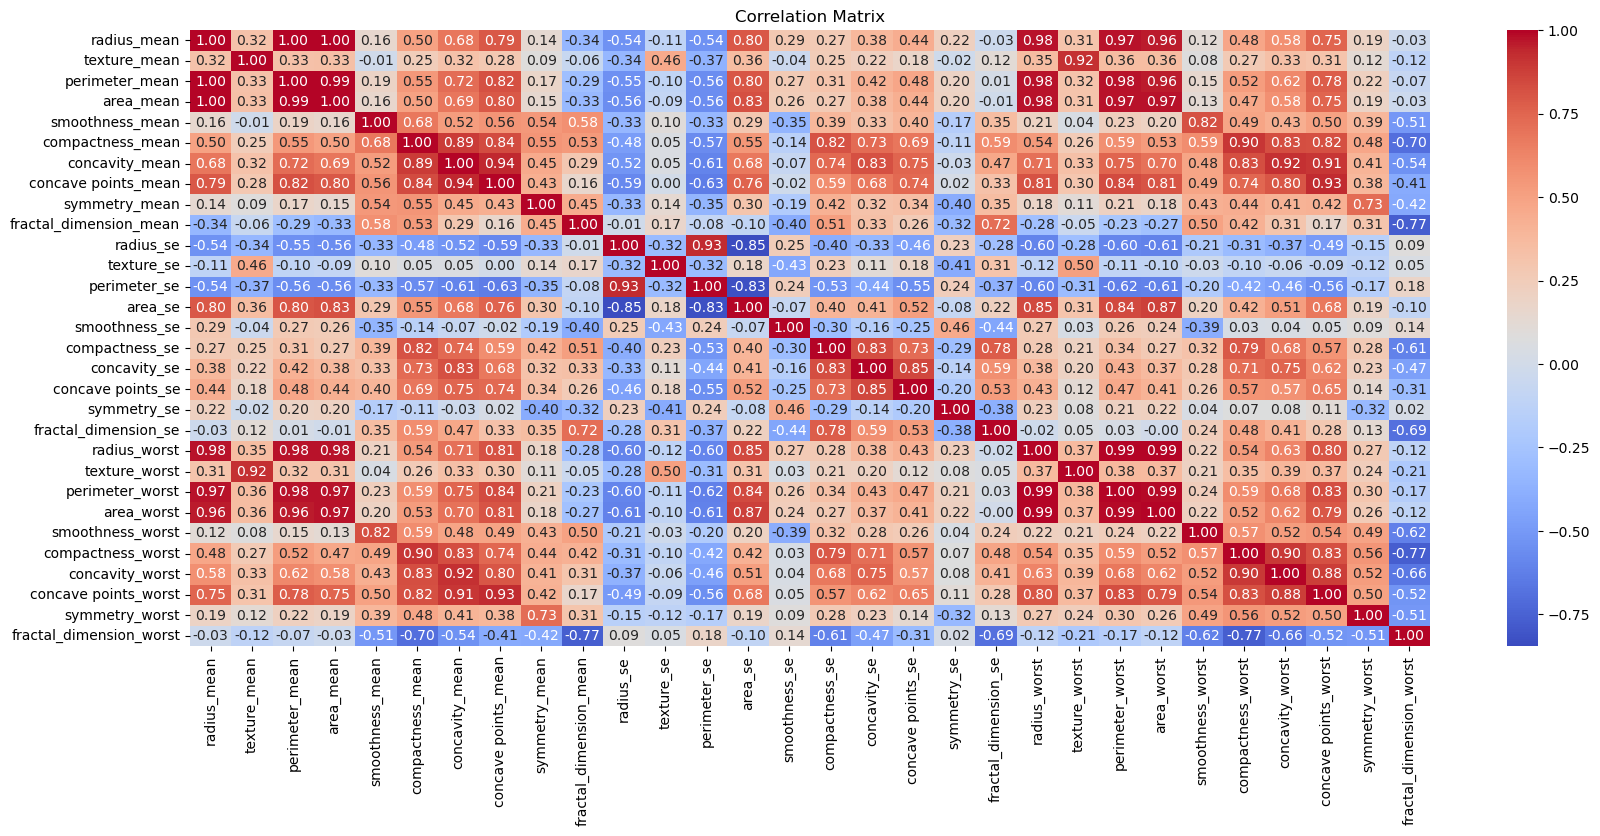

In [96]:
#Show correlation matrix
corr_matrix = breast_cancer_csv.drop(columns = 'diagnosis').corr() 
plt.figure(figsize = (20,8))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Correlation Matrix')
plt.show()

In [97]:
#Iterate over the df, dropping the variable with the highest average correlation with other variables until a stop condition
breast_cancer2 = breast_cancer_csv.copy().drop(columns = 'diagnosis') #Drop target variable
dropped_features = []
iteration = 1

while True:
    # Step 1: Correlation matrix
    corr_matrix = breast_cancer2.corr(numeric_only=True)
    
    # Step 2: Average absolute correlation (excluding self)
    avg_corr_all = corr_matrix.apply(lambda x: x.drop(x.name).abs().mean(), axis=0)
    avg_corr_sorted = avg_corr_all.sort_values(ascending=False)

    # Step 3: Check highest average correlation
    top_feature = avg_corr_sorted.index[0]
    top_avg_corr = avg_corr_sorted.iloc[0]

    # Step 4: Log current iteration
    print(f"Iteration {iteration}:")
    print(f"  Dropping feature: {top_feature}")
    print(f"  Average correlation: {top_avg_corr:.4f}")
    print(f"  Features remaining: {len(breast_cancer2.columns) - 1}")
    print("-" * 40)

    # Step 5: Stopping condition
    if top_avg_corr <= 0.3:
        print("Stopping: All features now have avg correlation ≤ 0.3")
        break

    # Step 6: Drop the most correlated feature
    dropped_features.append((top_feature, top_avg_corr))
    breast_cancer2 = breast_cancer2.drop(columns=top_feature)

    iteration += 1

# Final result
print("\nDropped features (in order):")
for feat, corr in dropped_features:
    print(f"  {feat}: avg corr = {corr:.4f}")

print("\nRemaining features:")
print(breast_cancer2.columns.tolist())


Iteration 1:
  Dropping feature: concavity_mean
  Average correlation: 0.5806
  Features remaining: 29
----------------------------------------
Iteration 2:
  Dropping feature: concave points_worst
  Average correlation: 0.5580
  Features remaining: 28
----------------------------------------
Iteration 3:
  Dropping feature: concave points_mean
  Average correlation: 0.5420
  Features remaining: 27
----------------------------------------
Iteration 4:
  Dropping feature: compactness_mean
  Average correlation: 0.5270
  Features remaining: 26
----------------------------------------
Iteration 5:
  Dropping feature: perimeter_worst
  Average correlation: 0.4872
  Features remaining: 25
----------------------------------------
Iteration 6:
  Dropping feature: concavity_worst
  Average correlation: 0.4762
  Features remaining: 24
----------------------------------------
Iteration 7:
  Dropping feature: compactness_worst
  Average correlation: 0.4472
  Features remaining: 23
---------------

In [100]:
#Check average correlation of all remaining features
avg_corr_all = corr_matrix.apply(lambda x: x.drop(x.name).abs().mean(), axis=0)
avg_corr_sorted = avg_corr_all.sort_values(ascending=False)
print(avg_corr_sorted)

concavity_se               0.290489
smoothness_worst           0.287452
fractal_dimension_worst    0.283236
smoothness_mean            0.282336
fractal_dimension_se       0.279303
radius_mean                0.262219
texture_worst              0.259290
area_mean                  0.257554
smoothness_se              0.255730
symmetry_worst             0.252393
texture_mean               0.230135
texture_se                 0.226805
symmetry_se                0.204541
dtype: float64


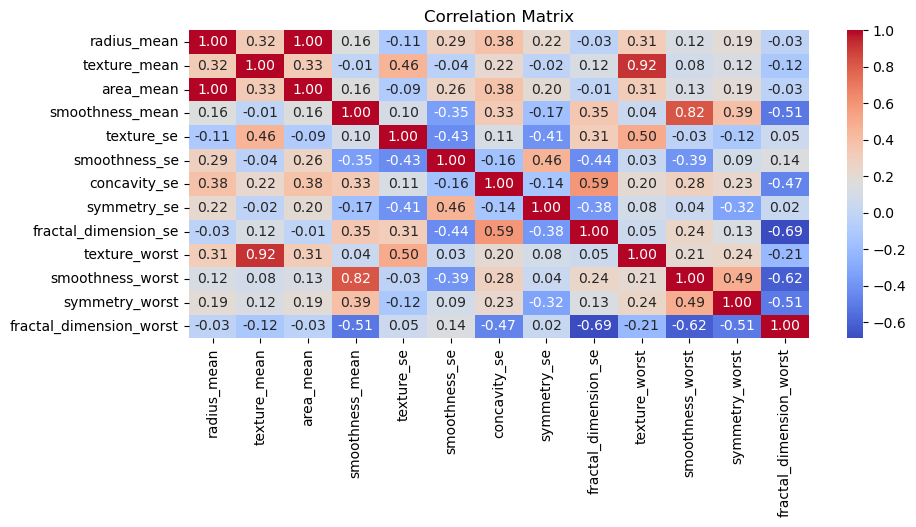

In [102]:
#Show correlation matrix
corr_matrix = breast_cancer2.corr()
plt.figure(figsize = (10,4))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Correlation Matrix')
plt.show()

In [104]:
#Add target variable back into the df
breast_cancer2['diagnosis'] = breast_cancer_csv['diagnosis']
#Save as a new csv
breast_cancer2.to_csv('/Users/annaxu/Documents/Data Science/DATA/breast-cancer-wisconsin-data-Dropped.csv')
breast_cancer2.describe()

,radius_mean,texture_mean,area_mean,smoothness_mean,texture_se,smoothness_se,concavity_se,symmetry_se,fractal_dimension_se,texture_worst,smoothness_worst,symmetry_worst,fractal_dimension_worst,diagnosis
count,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000
mean,1.137214,1.274423,8.442194,-2.349825,1.043618,162.593226,0.291553,54.819787,0.150298,3.217784,-2.034545,-0.545395,12.357409,0.371886
std,0.101774,0.096005,1.366613,0.144309,0.147182,56.615765,0.085278,16.911778,0.027132,0.241235,0.170344,0.085397,2.232518,0.483739
min,0.843918,0.987219,5.235409,-2.944469,0.711510,32.123354,0.000000,12.666244,0.096363,2.486572,-2.475868,-0.805208,4.819277,0.000000
25%,1.068557,1.208710,7.490952,-2.448999,0.939893,123.148997,0.247127,42.877229,0.131066,3.050219,-2.146864,-0.600846,10.860711,0.000000
50%,1.126294,1.275426,8.200158,-2.344814,1.030400,157.171087,0.295774,53.404543,0.146767,3.236519,-2.029509,-0.549058,12.488293,0.000000
75%,1.198107,1.337758,9.215675,-2.252843,1.137031,193.061995,0.345945,66.390965,0.165252,3.395596,-1.923635,-0.497198,13.922245,1.000000
max,1.434888,1.594171,13.103707,-1.811554,1.573523,374.953131,0.535430,104.832792,0.283809,3.902780,-1.502379,-0.177963,18.112661,1.000000


### 3. Logistic Regression Model

#### 3.1 Use Logistic Regression

Use Logistic Regression and examine accuracy score, confusion matrix, classification report for that model.

- Define Target, Predictors
- Train-Test Split
- Evaluate Model

In [145]:
#Define target and predictors variables
X = breast_cancer2.drop(columns='diagnosis')
y = breast_cancer2['diagnosis']

# Scale only the predictor variables
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 1)

#Fit logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

#Print accuracy score
y_pred = logistic_model.predict(X_test)
print('Accuracy score: {:.2%}'.format(accuracy_score(y_test, y_pred)))

Accuracy score: 97.16%


In [147]:
#Print confusion matrix 
array = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix = pd.DataFrame(array, columns = ['predicted_health', 'predicted_cancer'], index = ['is_healthy', 'is_cancer'])
print(confusion_matrix)

            predicted_health  predicted_cancer
is_healthy                87                 1
is_cancer                  3                50


In [149]:
#Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        88
           1       0.98      0.94      0.96        53

    accuracy                           0.97       141
   macro avg       0.97      0.97      0.97       141
weighted avg       0.97      0.97      0.97       141



Efficacy of the logistic model
- Precision: Out of the 51 cancer predictions, the model got 98% correct.
- Recall - Out of the 53 cancer cases, the model predicted 94% correctly.
- A F1 Score of 0.96 shows the model performed very well.
- Support shows there were 141 cases in the test dataset, 53 of which had cancer and 88 of which didn't.

### 4. Support Vector Machine

#### 4.1 Use Support Vector Machine

Use Support Vector Machine and examine accuracy score, confusion matrix, classification report for that model.

- Define Target, Predictors
- Train-Test Split
- Evaluate Model

In [117]:
#Define target and predictors variables
X = breast_cancer2.drop(columns='diagnosis')
y = breast_cancer2['diagnosis']

# Scale only the predictor variables
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 1)

#Fit logistic regression model
svm_model = SVC(probability=True) #SVMs don't inherently output probabilities and we need this for predict_proba later.
svm_model.fit(X_train, y_train)

#Print accuracy score
y_pred = svm_model.predict(X_test)
print('Accuracy score: {:.2%}'.format(accuracy_score(y_test, y_pred)))

Accuracy score: 96.45%


In [119]:
#Print confusion matrix 
array = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix = pd.DataFrame(array, columns = ['predicted_health', 'predicted_cancer'], index = ['is_healthy', 'is_cancer'])
print(confusion_matrix)

            predicted_health  predicted_cancer
is_healthy                87                 1
is_cancer                  4                49


In [121]:
#Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        88
           1       0.98      0.92      0.95        53

    accuracy                           0.96       141
   macro avg       0.97      0.96      0.96       141
weighted avg       0.97      0.96      0.96       141



Efficacy of the logistic model

- Precision: Out of the 50 cancer predictions, the model got 98% correct.
- Recall - Out of the 53 cancer cases, the model predicted 92% correctly.
- A F1 Score of 0.95 shows the model performed very well but less well than the logistic regression model.
- Support shows there were 141 cases in the test dataset, 53 of which had cancer and 88 of which didn't.

### 5. Naive Bayes
#### 5.1 Use Naive Bayes

Use Naive Bayes and examine accuracy score, confusion matrix, classification report for that model.

- Define Target, Predictors
- Train-Test Split
- Evaluate Model

In [124]:
#Define target and predictors variables
X = breast_cancer2.drop(columns='diagnosis')
y = breast_cancer2['diagnosis']

# Scale only the predictor variables
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 1)

#Fit logistic regression model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

#Print accuracy score
y_pred = nb_model.predict(X_test)
print('Accuracy score: {:.2%}'.format(accuracy_score(y_test, y_pred)))

Accuracy score: 97.16%


In [126]:
#Print confusion matrix 
array = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix = pd.DataFrame(array, columns = ['predicted_health', 'predicted_cancer'], index = ['is_healthy', 'is_cancer'])
print(confusion_matrix)

            predicted_health  predicted_cancer
is_healthy                88                 0
is_cancer                  4                49


In [128]:
#Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        88
           1       1.00      0.92      0.96        53

    accuracy                           0.97       141
   macro avg       0.98      0.96      0.97       141
weighted avg       0.97      0.97      0.97       141



Efficacy of the naive-bayes model

- Precision: Out of the 49 cancer predictions, the model got 100% correct.
- Recall - Out of the 53 cancer cases, the model predicted 92% correctly.
- A F1 Score of 0.96 shows the model performed well, better than the SVM model and comparable to the logistic regression model.
- Support shows there were 141 cases in the test dataset, 53 of which had cancer and 88 of which didn't.

### 6 Gridsearch optimal parameters for Logistic Regression and SVM models

Is there any difference between accuracy score of Logistic Regression and SVM? Use grid search to find optimal parameter for both these models.

> Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes. Typical examples include C, kernel and gamma for Support Vector Classifier, alpha for Lasso, etc.

> It is possible and recommended to search the hyper-parameter space for the best cross validation score.

> https://scikit-learn.org/stable/modules/grid_search.html#grid-search

**Note:** It'll take time to execute this. After running the cell, wait for result.

#### 6.1 Find Best Estimator For Logistic Regression

Find out how these parameters effect model. Find out the best estimator, score.

In [133]:
logistic_model = LogisticRegression(solver='liblinear', max_iter=1000) #liblinear solver required for L1 lasso penalty (default solver is lbfgs).
lr_params = { 'penalty': ['l1','l2'], 'C': [0.01, 0.1, 1, 10] } #dictionary of hyperparameters to encourage simplicity and prevent overfitting; R1 lasso can zero out some coefficients, R2 ridge shrinks but keeps all coefficients, lower values gets stronger regularisation. 
lr_gs = GridSearchCV(logistic_model, lr_params, cv=5,verbose = 1) #searches all combinations of parameters using 5-fold cross validation.
lr_gs.fit(X_train, y_train)
print("Best parameters:", lr_gs.best_params_)
print("Best score:", lr_gs.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'C': 10, 'penalty': 'l1'}
Best score: 0.9738375350140057


In [135]:
#The model using ridge regularisation and C = 10 (moderate-to-weak regularisation) produced the best results during cross-validation.

#### 6.2 Find Best Estimator For SVM

Find out how these parameters effect model. Find out the best estimator, score.

In [138]:
svm_params = {'C': [0.01, 0.1, 1, 10], 'gamma': [0.001, 0.0001], 'kernel': ['linear','rbf']} #Low gamma means points far away influence the decision boundary for a smoother, simpler model.
svm_gs = GridSearchCV(SVC(probability=True), svm_params, cv=5, verbose=1)
svm_gs.fit(X_train, y_train)
print("Best parameters:", svm_gs.best_params_)
print("Best score:", svm_gs.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
Best score: 0.9762184873949581


In [140]:
#GridSearchCV may yield lower scores than our manually trained models because the data is split into 5-folds (our manual models may be slightly overfit) and our manual models are a single random sample whereas GridSearchCV aims for robustness and better generalisation. 

#### 6.3 Plot the ROC curve for the SVM, Logistic Regressions and Naive Bayes on the same plot

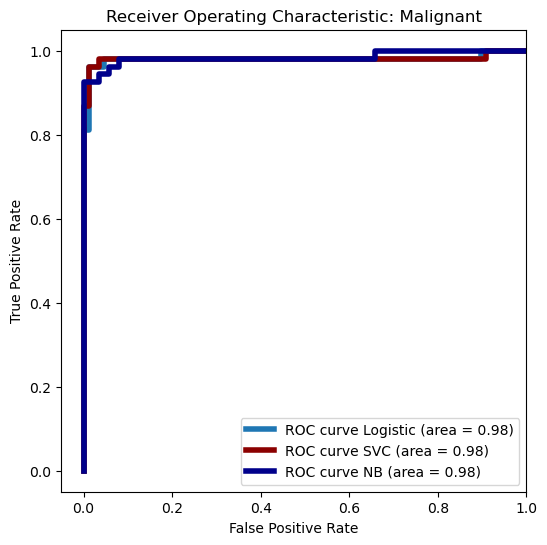

In [152]:
#Plot the ROC curves of our manual models (not using GridSearchCV)
logistic_preds = logistic_model.predict_proba(X_test)[:,1]
svm_preds = svm_model.predict_proba(X_test)[:,1]
nb_preds = nb_model.predict_proba(X_test)[:,1]

fpr_log, tpr_log, _ = roc_curve(y_test, logistic_preds)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_preds)
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_preds)

plt.figure(figsize=[6,6])

plt.plot(fpr_log, tpr_log, label='ROC curve Logistic (area = %0.2f)' % auc(fpr_log, tpr_log), linewidth=4)
plt.plot(fpr_svm, tpr_svm, label='ROC curve SVC (area = %0.2f)' % auc(fpr_svm, tpr_svm), linewidth=4, color='darkred')
plt.plot(fpr_nb, tpr_nb, label='ROC curve NB (area = %0.2f)' % auc(fpr_nb, tpr_nb), linewidth=4, color='darkblue')
    
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic: Malignant')
plt.legend(loc="lower right")
plt.show()

### 7. [BONUS] Learning Curve

A learning curve compares the validation and training performance of an estimator for varying amounts of training data. If both the validation and training score converge to a value that is too low, we will not benefit much from more training data.

Plot "learning curves" for the best models of each. This is a great way see how training/testing size affects the scores. Look at the documentation for how to use this function in sklearn.

http://scikit-learn.org/stable/modules/learning_curve.html#learning-curves

**References**

[Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/downloads/breast-cancer-wisconsin-data.zip/2)

[Validation curves: plotting scores to evaluate models](https://scikit-learn.org/stable/modules/learning_curve.html#learning-curves)

[In-Depth: Support Vector Machines](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)

[Understanding Support Vector Machine algorithm from examples (along with code)](https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/)

[Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)



---



---



> > > > > > > > > © 2025 Institute of Data


---



---



